# Titanic dataset: Decision Tree Classifier

### Description

This notebook sets out an approach for building a predictive model for the Titanic disaster. A decision tree classifier model will be trained and evaluated using data from Kaggle.

Goal: use a Decison Tree Classifer model to generate predictions for whether an individual will survive the titanic disaster.



**Feature descriptors:**
 - Pclass: ticket class
 - Name: full name of passenger
 - Sex: sex (m/f)
 - Age: age in years
 - SibSp: # of siblings/spouses aboard
 - Parch: # of parents / children aboard the Titanic
 - Ticket: ticket number
 - Fare: passenger fare
 - Cabin: cabin number
 - Embarked: port of embarkation
 
 
Target: Survival - whether the individual survived (0 - No, 1 - Yes)

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

**Load datasets**

In [2]:
train_df = pd.read_csv("../datasets/train.csv")
test_df = pd.read_csv("../datasets/test.csv")

**Explore training data**

see Titanic_EDA.ipynb for a more in-depth EDA exercise

In [3]:
# look at the first 10 rows
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
'''
# print some information about the dataset
print(train_df.columns,
      train_df.shape[0],
      train_df.describe(),
      train_df.isna().sum(),
      train_df.dtypes, sep='\n\n')
for col in ['Pclass','Sex','SibSp','Parch','Embarked']:
    print(train_df[col].unique(),sep='\n')
'''

In [ ]:
# explore range and distribution of values for each age, sex, pclass, sibsp, parch, fare, cabin, embarked 
# name and ticket look to be not helpful - further investigation?
# how do the features correlate with one another?
# how do each of the features correlate with the target?

In [3]:
# set passenger id as the index
train_df.set_index('PassengerId',inplace=True)
test_df.set_index('PassengerId',inplace=True)

### Feature engineering

The name and ticket columns have been dropped as they contain all unique values and appear unlikely to be useful to the model. The cabin column has a large number of nan values and so this has also been excluded. Then, the remaining rows with nan values have been dropped.

Made the same change on the test dataset.

In [47]:
# name includes title which could be extracted using regex. This could also be an indicator (Mr, Mrs, Miss, Master, Dr., Rev.) 
# for example, indicates whether the passenger is married or not.  
#train_df['Title'] = train_df['Name'].str.extract('([a-zA-Z]{2,}[\.]{1})')
#test_df['Title'] = test_df['Name'].str.extract('([a-zA-Z]{2,}[\.]{1})')

In [4]:
# create new dataframe with cleaned dataset
cleaned_train_df = train_df.drop(columns=['Name','Ticket','Cabin']).dropna(axis=0).copy()
cleaned_test_df = test_df.drop(columns=['Name','Ticket','Cabin']).dropna(axis=0).copy()

In [45]:
# is there another way to use the nan values other than dropping them?
# cabin could be a good indicator as likely encoded the location on the ship of the passenger

# name includes title which could be extracted using regex. This could also be an indicator (Mr, Mrs, Miss, Master, Dr., Rev.) 
# for example, indicates whether the passenger is married or not.  

# Consider whether to bin fields, like age for example, into categories. Age is unlikley to be useful as a continuous variable. 

**Categoric data**

Use One hot encoding to convert the categoric variables (sex, embarked, parch, Pclass, SibSp) so each category is a feature (1/0) 

This has to be done for both test and training datasets

In [5]:
# one hot encode categoric variables
train_ohe_df = pd.get_dummies(cleaned_train_df,columns=['Sex','Embarked','Parch','Pclass','SibSp'])
test_ohe_df = pd.get_dummies(cleaned_test_df,columns=['Sex','Embarked','Parch','Pclass','SibSp'])

**Numeric data**

Any fields containing continuous numeric data should be scaled or normalized.

In [6]:
from sklearn.preprocessing import StandardScaler, minmax_scale

# fit and apply a scaler to the training set for the Age variable
age_scaler = StandardScaler().fit(train_ohe_df['Age'].values.reshape(-1, 1))
train_ohe_df['Age'] = age_scaler.transform(train_ohe_df['Age'].values.reshape(-1, 1))

# fit and apply a scaler to the test set for the Fare variable
fare_scaler = StandardScaler().fit(train_ohe_df['Fare'].values.reshape(-1, 1))
train_ohe_df['Fare'] = age_scaler.transform(train_ohe_df['Fare'].values.reshape(-1, 1))

# apply the scaler to the test set
test_ohe_df['Age'] = age_scaler.transform(test_ohe_df['Age'].values.reshape(-1, 1))
test_ohe_df['Fare'] = fare_scaler.transform(test_ohe_df['Fare'].values.reshape(-1, 1))

**Create feature and target datasets**

In [7]:
target_col = ['Survived']
feature_cols=[f for f in train_ohe_df.columns.to_list() if f not in target_col]

X = train_ohe_df[feature_cols].copy()
y = train_ohe_df[target_col].copy()

X_inf = test_ohe_df[feature_cols].copy()

Split the training data into train and test sets for fitting and evaluation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

In [107]:
X_train

,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Parch_0,Parch_1,Parch_2,...,Parch_6,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5
PassengerId,,,,,,,,,,,,,,,,,,,,,
737,1.267570,0.326796,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
841,-0.665764,-1.499514,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
562,0.715189,-1.501530,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
120,-1.908622,0.112748,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
472,0.577094,-1.448592,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.646142,-1.149097,0,1,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,0,0
341,-1.908622,-0.251478,0,1,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
755,1.267570,2.441380,1,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0


## Model evaluation

**Train ML model**: train the decision tree classifer on the training dataset. 

**Evaluation**: what metric should this model be optimised for? 


Use a dummy classifier to benchmark the evaluation with a bad score.

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, auc, roc_auc_score
from sklearn.dummy import DummyClassifier

In [69]:
# create an evaluation function for repetitive evaluation 
def model_evaluation(model, X_train, y_train, X_test, y_test):
    print('Confusion matrix on training dataset')
    print(confusion_matrix(y_train,model.predict(X_train)))
    print()
    print('Confusion matrix on test dataset')
    print(confusion_matrix(y_test,model.predict(X_test)))
    print()
    print('Classification report on training dataset')
    print(classification_report(y_train,model.predict(X_train)))
    print('Classification report on test dataset')
    print(classification_report(y_test,model.predict(X_test)))
    print()
    print(f'ROC AUC score on training set: {roc_auc_score(y_train,model.predict(X_train))}')
    print(f'ROC AUC score on test set: {roc_auc_score(y_test,model.predict(X_test))}')

In [70]:
# define a dummy classifier to benchmark the evaluation
dummy_model = DummyClassifier(strategy='uniform').fit(X_train,y_train)
model_evaluation(dummy_model, X_train, y_train, X_test, y_test)

Confusion matrix on training dataset
[[133 149]
 [104  91]]

Confusion matrix on test dataset
[[68 74]
 [46 47]]

Classification report on training dataset
              precision    recall  f1-score   support

           0       0.59      0.48      0.53       282
           1       0.41      0.53      0.46       195

    accuracy                           0.50       477
   macro avg       0.50      0.50      0.50       477
weighted avg       0.52      0.50      0.50       477

Classification report on test dataset
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       142
           1       0.39      0.52      0.45        93

    accuracy                           0.49       235
   macro avg       0.50      0.50      0.49       235
weighted avg       0.52      0.49      0.50       235


ROC AUC score on training set: 0.5156846699399891
ROC AUC score on test set: 0.4921247917613206


In [110]:
dummy_model2 = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
print(f'Dummy (most frequent) accuracy on training set: {dummy_model2.score(X_train,y_train)}')
print(f'Dummy (most frequent) accuracy on test set: {dummy_model2.score(X_test,y_test)}')

Dummy (most frequent) accuracy on training set: 0.5911949685534591
Dummy (most frequent) accuracy on test set: 0.6042553191489362


In [10]:
# decision tree model training and evaluation
dtc_model = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_train,y_train)
#model_evaluation(dtc_model, X_train, y_train, X_test, y_test)

In [11]:
# OPTIONAL: save the model as a pickle file
import pickle
filename ='dtc_model.sav'
pickle.dump(dtc_model, open(filename, 'wb'))

In [21]:
preds = dtc_model.predict(X_test)

In [23]:
results = X_test.copy()
results['preds'] = preds
results

,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Parch_0,Parch_1,Parch_2,...,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,preds
PassengerId,,,,,,,,,,,,,,,,,,,,,
424,-0.113383,-1.052431,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
117,2.821143,-1.511598,0,1,0,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
133,1.198523,-1.045526,1,0,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,0,0
749,-0.734812,1.619713,0,1,0,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0
73,-0.596716,3.028286,0,1,0,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.300903,-0.251478,0,1,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0
807,0.646142,-2.046717,0,1,0,0,1,1,0,0,...,1,0,0,1,0,0,0,0,0,0
450,1.543761,0.059236,0,1,0,0,1,1,0,0,...,1,0,0,1,0,0,0,0,0,0


In [26]:
list(X_test.loc[721].values)

[-1.632430989759686,
 0.231855615029561,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [106]:
# logistic regression training and evaluation
logreg_model = LogisticRegression().fit(X_train,y_train.values.ravel())
model_evaluation(logreg_model, X_train, y_train, X_test, y_test)

Confusion matrix on training dataset
[[244  38]
 [ 46 149]]

Confusion matrix on test dataset
[[124  18]
 [ 31  62]]

Classification report on training dataset
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       282
           1       0.80      0.76      0.78       195

    accuracy                           0.82       477
   macro avg       0.82      0.81      0.82       477
weighted avg       0.82      0.82      0.82       477

Classification report on test dataset
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       142
           1       0.78      0.67      0.72        93

    accuracy                           0.79       235
   macro avg       0.79      0.77      0.78       235
weighted avg       0.79      0.79      0.79       235


ROC AUC score on training set: 0.8146753955264594
ROC AUC score on test set: 0.7699530516431923


In [122]:
# SVM training and evaluation
svc_model = SVC(kernel='rbf').fit(X_train,y_train.values.ravel())
model_evaluation(svc_model, X_train, y_train, X_test, y_test)

Confusion matrix on training dataset
[[243  39]
 [ 51 144]]

Confusion matrix on test dataset
[[132  10]
 [ 31  62]]

Classification report on training dataset
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       282
           1       0.79      0.74      0.76       195

    accuracy                           0.81       477
   macro avg       0.81      0.80      0.80       477
weighted avg       0.81      0.81      0.81       477

Classification report on test dataset
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       142
           1       0.86      0.67      0.75        93

    accuracy                           0.83       235
   macro avg       0.84      0.80      0.81       235
weighted avg       0.83      0.83      0.82       235


ROC AUC score on training set: 0.8000818330605565
ROC AUC score on test set: 0.7981220657276995


### Hyperparameter tuning

It's worth investigating whether tweaking hyperparameters changes the performance of the SVM model.

Try using GridSearchCV which applies cross validation and hyperpameter tuning to find the best performing model.

In [111]:
from sklearn.model_selection import GridSearchCV

In [118]:
params = {'kernel':('linear','rbf'),'C':(1,10,100)}
clf = GridSearchCV(svc_model, params, cv=5, scoring='accuracy')
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 10, 100), 'kernel': ('linear', 'rbf')},
             scoring='accuracy')

In [123]:
# the grid search object can be called as model to generate predictions and score them
clf.score(X_test,y_test.values.ravel())

0.8170212765957446

In [119]:
# retrieve the best score from the training set splits and hyperparameter values
clf.best_score_

0.7903070175438596

In [120]:
# retrieve the parameters the model performed best with
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

### Decision Tree investigation

**Analysing the decision tree**

Can we explore the decisions made by the tree, and see which features were more important to the algorithm.

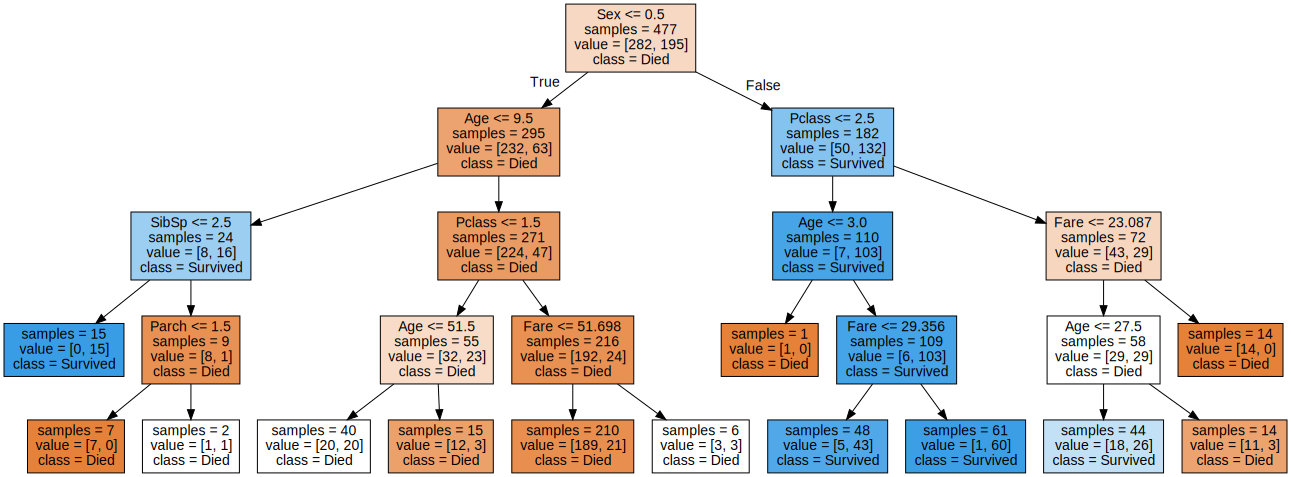

In [14]:
# review decisions made by the tree
export_graphviz(survival_classifier,out_file="tree.dot",
                class_names=["Died","Survived"],
                feature_names=feature_cols,
                impurity=False,
                filled=True)

with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

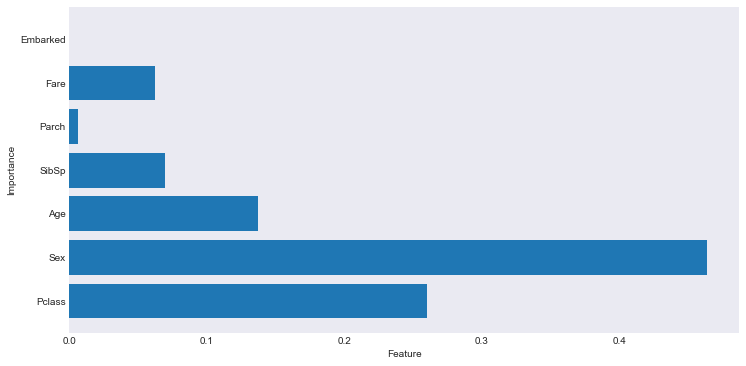

In [24]:
# review the feature importances
fig = plt.figure(figsize=(12,6))
plt.style.use('seaborn-dark')
plt.barh(feature_cols,survival_classifier.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Importance');

In [ ]:
# benchmark the score and then try to improve upon it
# what other metrics could be used and what results do these provide?
# write a function to store the scoring results to a csv

## Random Forests

**Train the ML model**

In [36]:
rfc = RandomForestClassifier(n_estimators=5,max_features=3,random_state=0)
rfc.fit(X_train.values,np.ravel(y_train))

RandomForestClassifier(max_features=3, n_estimators=5, random_state=0)

In [38]:
print(f"Accuracy on training set: {rfc.score(X_train.values,np.ravel(y_train))}")
print(f"Accuracy on test set: {rfc.score(X_test.values,np.ravel(y_test))}")

Accuracy on training set: 0.9643605870020965
Accuracy on test set: 0.7787234042553192


**Hyperparameter tuning**

In [39]:
# From the below we can see best performance is at max_features = 3 or 4
scores=[]
for mf in range(1,8):
    model = RandomForestClassifier(n_estimators=5,max_features=mf, random_state=0)
    model.fit(X_train.values,np.ravel(y_train))
    score = model.score(X_test.values,np.ravel(y_test))
    scores.append(score)
    print(f"Max features is {mf} and score is {score}")

Max features is 1 and score is 0.7574468085106383
Max features is 2 and score is 0.7617021276595745
Max features is 3 and score is 0.7787234042553192
Max features is 4 and score is 0.7787234042553192
Max features is 5 and score is 0.7574468085106383
Max features is 6 and score is 0.774468085106383
Max features is 7 and score is 0.7574468085106383


In [40]:
# From the below we can see best performance is at n_estimators = 4
scores=[]
for numtrees in range(1,11):
    model = RandomForestClassifier(n_estimators=numtrees, max_features=3, random_state=0)
    model.fit(X_train.values,np.ravel(y_train))
    score = model.score(X_test.values,np.ravel(y_test))
    scores.append(score)
    print(f"Number of trees is {numtrees} and score is {score}")

Number of trees is 1 and score is 0.7489361702127659
Number of trees is 2 and score is 0.7659574468085106
Number of trees is 3 and score is 0.7829787234042553
Number of trees is 4 and score is 0.7914893617021277
Number of trees is 5 and score is 0.7787234042553192
Number of trees is 6 and score is 0.774468085106383
Number of trees is 7 and score is 0.7829787234042553
Number of trees is 8 and score is 0.7872340425531915
Number of trees is 9 and score is 0.7872340425531915
Number of trees is 10 and score is 0.774468085106383


In [41]:
# lets try all combinations of num features and num trees. Ten trees with 6 features seems to yield best result
scores=[]
for mf in range(1,8):
    for numtrees in range(1,11):
        model = RandomForestClassifier(n_estimators=numtrees, max_features=mf, random_state=0)
        model.fit(X_train.values,np.ravel(y_train))
        score = model.score(X_test.values,np.ravel(y_test))
        scores.append(score)
        print(f"Number of trees is {numtrees} and max features is {mf} and score is {score}")

Number of trees is 1 and max features is 1 and score is 0.6851063829787234
Number of trees is 2 and max features is 1 and score is 0.6978723404255319
Number of trees is 3 and max features is 1 and score is 0.7319148936170212
Number of trees is 4 and max features is 1 and score is 0.7446808510638298
Number of trees is 5 and max features is 1 and score is 0.7574468085106383
Number of trees is 6 and max features is 1 and score is 0.7574468085106383
Number of trees is 7 and max features is 1 and score is 0.7574468085106383
Number of trees is 8 and max features is 1 and score is 0.7787234042553192
Number of trees is 9 and max features is 1 and score is 0.7829787234042553
Number of trees is 10 and max features is 1 and score is 0.7829787234042553
Number of trees is 1 and max features is 2 and score is 0.7106382978723405
Number of trees is 2 and max features is 2 and score is 0.7617021276595745
Number of trees is 3 and max features is 2 and score is 0.7574468085106383
Number of trees is 4 and

## Gradient boosted trees

**Train the ML model**

In [43]:
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train.values,np.ravel(y_train))

GradientBoostingClassifier(random_state=0)

In [44]:
print(f"Accuracy on training set: {gbc.score(X_train.values,np.ravel(y_train))}")
print(f"Accuracy on test set: {gbc.score(X_test.values,np.ravel(y_test))}")

Accuracy on training set: 0.9161425576519916
Accuracy on test set: 0.8382978723404255


**Hyperparameter tuning**

In [47]:
# From the below we can see best performance is at a higher number of tress
scores=[]
for numtrees in range(1,8):
    model = GradientBoostingClassifier(n_estimators=numtrees,random_state=0)
    model.fit(X_train.values,np.ravel(y_train))
    score = model.score(X_test.values,np.ravel(y_test))
    scores.append(score)
    print(f"Number of trees is {numtrees} and score is {score}")

Number of trees is 1 and score is 0.6042553191489362
Number of trees is 2 and score is 0.7914893617021277
Number of trees is 3 and score is 0.7914893617021277
Number of trees is 4 and score is 0.7914893617021277
Number of trees is 5 and score is 0.7914893617021277
Number of trees is 6 and score is 0.7957446808510639
Number of trees is 7 and score is 0.7957446808510639


In [53]:
# From the below we can see better performance is with a learning rate around 0.1
scores=[]
for lr in np.arange(0.01,0.2,0.01):
    model = GradientBoostingClassifier(learning_rate=lr,random_state=0)
    model.fit(X_train.values,np.ravel(y_train))
    score = model.score(X_test.values,np.ravel(y_test))
    scores.append(score)
    print(f"Learning rate is {lr} and score is {score}")

Learning rate is 0.01 and score is 0.7957446808510639
Learning rate is 0.02 and score is 0.8085106382978723
Learning rate is 0.03 and score is 0.8170212765957446
Learning rate is 0.04 and score is 0.8170212765957446
Learning rate is 0.05 and score is 0.8212765957446808
Learning rate is 0.060000000000000005 and score is 0.825531914893617
Learning rate is 0.06999999999999999 and score is 0.825531914893617
Learning rate is 0.08 and score is 0.8297872340425532
Learning rate is 0.09 and score is 0.825531914893617
Learning rate is 0.09999999999999999 and score is 0.8382978723404255
Learning rate is 0.11 and score is 0.8382978723404255
Learning rate is 0.12 and score is 0.8297872340425532
Learning rate is 0.13 and score is 0.8382978723404255
Learning rate is 0.14 and score is 0.8127659574468085
Learning rate is 0.15000000000000002 and score is 0.8382978723404255
Learning rate is 0.16 and score is 0.825531914893617
Learning rate is 0.17 and score is 0.8340425531914893
Learning rate is 0.180000

In [54]:
# From the below we can see best performance is with a learning rate around 0.1
scores=[]
for numtrees in range(1,9):
    for lr in np.arange(0.05,0.15,0.01):
        model = GradientBoostingClassifier(n_estimators=numtrees,learning_rate=lr,random_state=0)
        model.fit(X_train.values,np.ravel(y_train))
        score = model.score(X_test.values,np.ravel(y_test))
        scores.append(score)
        print(f"Number of trees in {numtrees} and Learning rate is {lr} and score is {score}")

Number of trees in 1 and Learning rate is 0.05 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.060000000000000005 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.07 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.08000000000000002 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.09000000000000001 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.1 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.11000000000000001 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.12000000000000001 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.13 and score is 0.6042553191489362
Number of trees in 1 and Learning rate is 0.14 and score is 0.6042553191489362
Number of trees in 2 and Learning rate is 0.05 and score is 0.6042553191489362
Number of trees in 2 and Learning rate is 0.060000000000

## XGBoost

We should also compare sklearn's GradientBoost with XGBoost with is a different implementation of the same algorithm

In [61]:
xgbc = XGBClassifier(learning_rate=0.1,n_estimators=100,use_label_encoder=False)
xgbc.fit(X_train.values,np.ravel(y_train))

[17:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [63]:
# xgboost's performance is slightly worse than sklearn's equivalent using the same learning rate and number of trees
print(f"Accuracy on training set: {xgbc.score(X_train.values,np.ravel(y_train))}")
print(f"Accuracy on test set: {xgbc.score(X_test.values,np.ravel(y_test))}")

Accuracy on training set: 0.9475890985324947
Accuracy on test set: 0.8127659574468085
